## Import packages

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from glob import glob
from tqdm import tqdm
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Set random seeds to ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

## Dataset & Dataloader

In [3]:
Path = "D:/Data"
classes = list(os.listdir(f'{Path}/'))
num_classes = len(classes)
paths = glob(f'{Path}/*/*.jpg')
len(paths), len(classes)

(3000, 3)

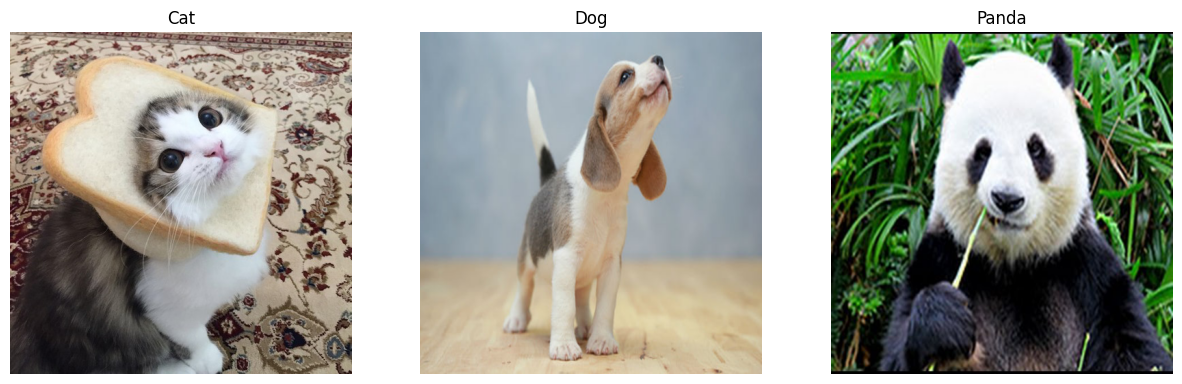

In [40]:
# Create figure and subplots
fig = plt.figure(figsize=(15, 5))
rows = 1
columns = 3

# Open images and resize to a uniform size (500x500)
Image1 = Image.open(Path + '/cat.jpg').resize((500, 500))
Image2 = Image.open(Path + '/dog.jpg').resize((500, 500))
Image3 = Image.open(Path + '/panda.jpg').resize((500, 500))

# Add subplot and display the first image
fig.add_subplot(rows, columns, 1)
plt.imshow(Image1)
plt.title("Cat")
plt.axis('off')

# Add subplot and display the second image
fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.title("Dog")
plt.axis('off')

# Add subplot and display the third image
fig.add_subplot(rows, columns, 3)
plt.imshow(Image3)
plt.title("Panda")
plt.axis('off')

# Display the figure
plt.show()

In [4]:
# Define data augmentation and transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = datasets.ImageFolder(root=Path, transform=transform)

# Calculate the size of each subset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Randomly split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(0))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## Modeling

In [5]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # Conv layer
            nn.ReLU(inplace=True),  # Activation layer
            nn.MaxPool2d(kernel_size=3, stride=2),  # Max pooling layer
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, len(classes))
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
# Initialize the model
AlexNet = AlexNet().cuda()

In [7]:
# summary(AlexNet, (3, 224, 224))

## Training

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, save_path=None):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    best_model = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Using tqdm for the training loop
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())
        
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Validation {epoch+1}/{num_epochs}', leave=False):
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc.item())

        # Save the best model
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model = model.state_dict()
            torch.save(best_model, f'{save_path}_best.pth')

        # if (epoch + 1) % 10 == 0:  # Print updates every 10 epochs
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, LR: {scheduler.get_last_lr()[0]:.8f}')
        
        scheduler.step()  # Step the scheduler
    
    # Load the best model weights
    model.load_state_dict(best_model)
    
    return model, train_loss, train_acc, val_loss, val_acc

In [9]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(AlexNet.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=1.0) # No learning rate decay


In [10]:
# Train the model
AlexNet, train_loss, train_acc, val_loss, val_acc = train_model(AlexNet, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, save_path='AlexNet')

Epoch 1/30, Train Loss: 1.1809, Train Acc: 0.4408, Val Loss: 0.9729, Val Acc: 0.5133, LR: 0.00100000


Epoch 2/30, Train Loss: 0.8705, Train Acc: 0.5383, Val Loss: 0.8329, Val Acc: 0.5300, LR: 0.00100000


Epoch 4/30, Train Loss: 0.8326, Train Acc: 0.5713, Val Loss: 0.8319, Val Acc: 0.5400, LR: 0.00100000


Epoch 5/30, Train Loss: 0.7990, Train Acc: 0.5721, Val Loss: 0.8199, Val Acc: 0.5433, LR: 0.00100000


Epoch 6/30, Train Loss: 0.7744, Train Acc: 0.5708, Val Loss: 0.8458, Val Acc: 0.5467, LR: 0.00100000


Epoch 8/30, Train Loss: 0.7168, Train Acc: 0.6046, Val Loss: 0.7858, Val Acc: 0.5833, LR: 0.00100000


Epoch 9/30, Train Loss: 0.6720, Train Acc: 0.6408, Val Loss: 0.7979, Val Acc: 0.5867, LR: 0.00100000


Epoch 11/30, Train Loss: 0.6577, Train Acc: 0.6462, Val Loss: 0.7468, Val Acc: 0.6433, LR: 0.00100000


Epoch 15/30, Train Loss: 0.5723, Train Acc: 0.7100, Val Loss: 0.7462, Val Acc: 0.6467, LR: 0.00100000


Epoch 17/30, Train Loss: 0.5044, Train Acc: 0.7463, Val Loss: 0.6963, Val Acc: 0.6867, LR: 0.00100000


Epoch 20/30, Train Loss: 0.4690, Train Acc: 0.7733, Val Loss: 0.8818, Val Acc: 0.7133, LR: 0.00100000


Epoch 21/30, Train Loss: 0.4186, Train Acc: 0.8046, Val Loss: 0.7342, Val Acc: 0.7167, LR: 0.00100000


Epoch 24/30, Train Loss: 0.3581, Train Acc: 0.8354, Val Loss: 0.8962, Val Acc: 0.7200, LR: 0.00100000


Epoch 25/30, Train Loss: 0.3295, Train Acc: 0.8529, Val Loss: 0.9114, Val Acc: 0.7433, LR: 0.00100000


## Evaluation

In [11]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    running_corrects = 0
    all_labels = []
    all_preds = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU
        outputs = model(inputs)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get predictions
        running_corrects += torch.sum(preds == labels.data)  # Count correct predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_preds.extend(preds.cpu().numpy())  # Store predicted labels

    test_acc = running_corrects.double() / len(test_loader.dataset)  # Calculate accuracy
    print(f'Test Acc: {test_acc:.4f}')

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'F1 Score: {f1:.4f}')
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

Test Acc: 0.7167
F1 Score: 0.7199


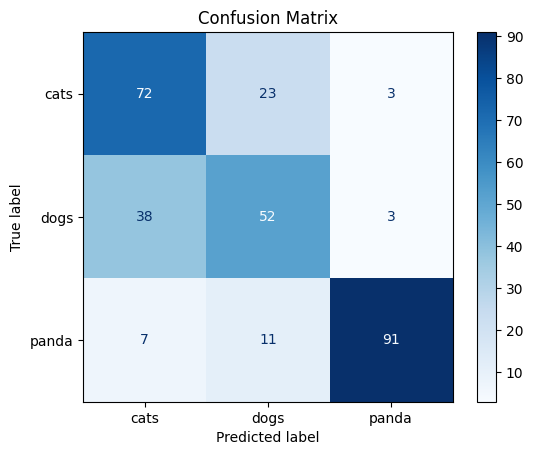

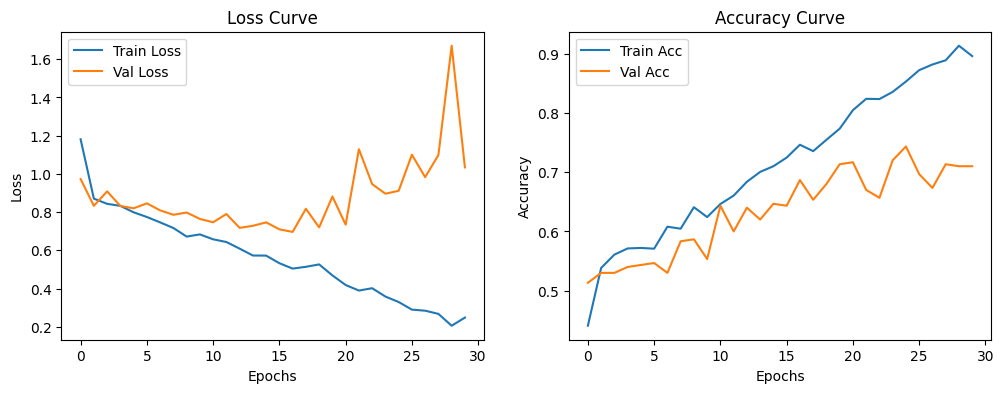

In [12]:
# Evaluate the model and generate confusion matrix
cm = evaluate_model(AlexNet, test_loader)

# Plot confusion matrix
labels = dataset.classes

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot training results
plt.figure(figsize=(12, 4))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

## Improvement 1: Data Augmentation

In [13]:
# Define the data augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomResizedCrop(224),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = datasets.ImageFolder(root=Path, transform=transform)

# Calculate the size of each subset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Randomly split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## Improvement 2: Model Architecture

In [14]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet50(num_classes=3):
    model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes)
    return model

# Create the model
resnet50_1 = resnet50(num_classes=num_classes)

# Change the fully connected layer as required
resnet50_1.fc = nn.Sequential(
    nn.Linear(512 * Bottleneck.expansion, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes),
    nn.Softmax(dim=1)
)

# Initialize the model
resnet50_1 = resnet50_1.cuda()

In [15]:
# summary(resnet50_1, (3, 224, 224))

## Improvement 3: learning rate scheduler

In [24]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(resnet50_1.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=25, gamma=0.5) # Reduce the learning rate by half every 5 epochs


## Training

In [25]:
# Train the model
resnet50_1, train_loss, train_acc, val_loss, val_acc = train_model(resnet50_1, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, save_path='resnet50_1')

Epoch 1/100, Train Loss: 0.8693, Train Acc: 0.6729, Val Loss: 0.9342, Val Acc: 0.6133, LR: 0.00100000


Epoch 4/100, Train Loss: 0.8369, Train Acc: 0.6971, Val Loss: 0.9181, Val Acc: 0.6200, LR: 0.00100000


Epoch 5/100, Train Loss: 0.8199, Train Acc: 0.7229, Val Loss: 0.8370, Val Acc: 0.7000, LR: 0.00100000


Epoch 14/100, Train Loss: 0.8205, Train Acc: 0.7233, Val Loss: 0.8408, Val Acc: 0.7033, LR: 0.00100000


Epoch 16/100, Train Loss: 0.8053, Train Acc: 0.7342, Val Loss: 0.8292, Val Acc: 0.7300, LR: 0.00100000


Epoch 33/100, Train Loss: 0.7523, Train Acc: 0.7900, Val Loss: 0.8109, Val Acc: 0.7367, LR: 0.00050000


Epoch 34/100, Train Loss: 0.7626, Train Acc: 0.7821, Val Loss: 0.7997, Val Acc: 0.7467, LR: 0.00050000


Epoch 36/100, Train Loss: 0.7482, Train Acc: 0.7958, Val Loss: 0.7940, Val Acc: 0.7500, LR: 0.00050000


Epoch 45/100, Train Loss: 0.7311, Train Acc: 0.8171, Val Loss: 0.7865, Val Acc: 0.7600, LR: 0.00050000


Epoch 49/100, Train Loss: 0.7233, Train Acc: 0.8179, Val Loss: 0.7866, Val Acc: 0.7633, LR: 0.00050000


Epoch 52/100, Train Loss: 0.6984, Train Acc: 0.8475, Val Loss: 0.7744, Val Acc: 0.7733, LR: 0.00025000


Epoch 53/100, Train Loss: 0.7054, Train Acc: 0.8404, Val Loss: 0.7688, Val Acc: 0.7767, LR: 0.00025000


Epoch 55/100, Train Loss: 0.6956, Train Acc: 0.8488, Val Loss: 0.7693, Val Acc: 0.7800, LR: 0.00025000


Epoch 62/100, Train Loss: 0.6862, Train Acc: 0.8638, Val Loss: 0.7655, Val Acc: 0.7900, LR: 0.00025000


Epoch 65/100, Train Loss: 0.6950, Train Acc: 0.8529, Val Loss: 0.7415, Val Acc: 0.8000, LR: 0.00025000


Epoch 77/100, Train Loss: 0.6705, Train Acc: 0.8779, Val Loss: 0.7336, Val Acc: 0.8200, LR: 0.00012500


Epoch 100/100, Train Loss: 0.6478, Train Acc: 0.8975, Val Loss: 0.7126, Val Acc: 0.8433, LR: 0.00012500


## Evaluation

Test Acc: 0.8600
F1 Score: 0.8603


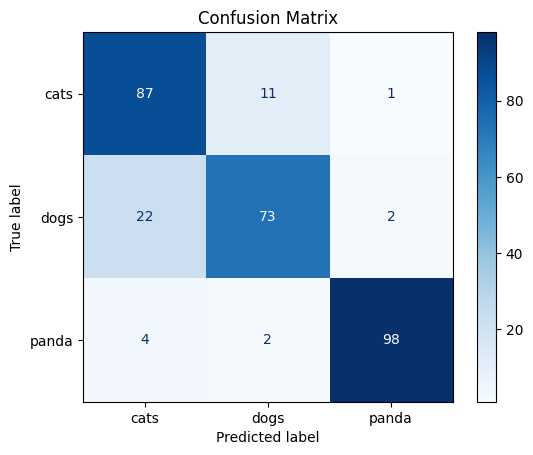

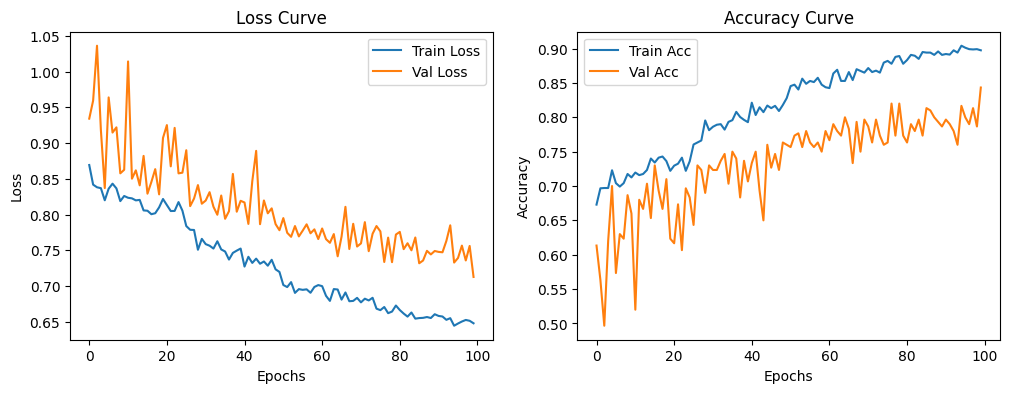

In [26]:
# Evaluate the model and generate confusion matrix
cm = evaluate_model(resnet50_1, test_loader)

# Plot confusion matrix
labels = dataset.classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot training results
plt.figure(figsize=(12, 4))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

## Improvement 4: Useing pretrained weight

In [19]:
# Load the pre-trained ResNet-50 model
resnet50_2 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# freeze the pre-trained layers
for param in resnet50_2.parameters():
    param.requires_grad = False

# change the output layer
resnet50_2.fc = nn.Sequential(
    nn.Linear(resnet50_2.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes),
    nn.Softmax(dim=1)
)
resnet50_2 = resnet50_2.cuda()  # Move the model to GPU

In [20]:
# summary(resnet50_2, (3, 224, 224))

In [21]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(resnet50_2.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # Reduce the learning rate by half every 5 epochs

## Training

In [22]:
# Train the model
resnet50_2, train_loss, train_acc, val_loss, val_acc = train_model(resnet50_2, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, save_path='ResNet50_2')

Epoch 1/30, Train Loss: 0.6658, Train Acc: 0.9413, Val Loss: 0.5939, Val Acc: 0.9567, LR: 0.00100000


Epoch 2/30, Train Loss: 0.5708, Train Acc: 0.9829, Val Loss: 0.5865, Val Acc: 0.9700, LR: 0.00100000


Epoch 4/30, Train Loss: 0.5631, Train Acc: 0.9904, Val Loss: 0.5792, Val Acc: 0.9767, LR: 0.00100000


Epoch 19/30, Train Loss: 0.5559, Train Acc: 0.9963, Val Loss: 0.5728, Val Acc: 0.9800, LR: 0.00010000


## Evaluation

Test Acc: 0.9767
F1 Score: 0.9767


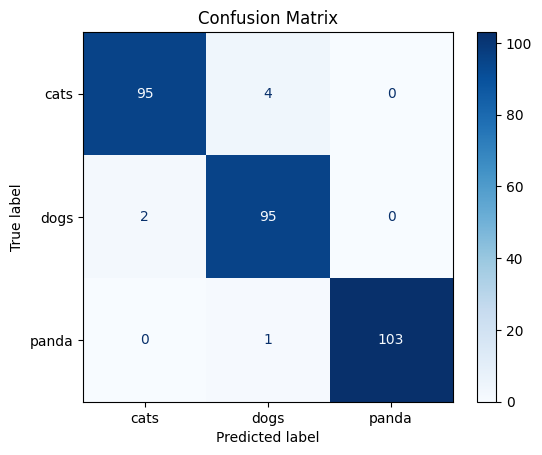

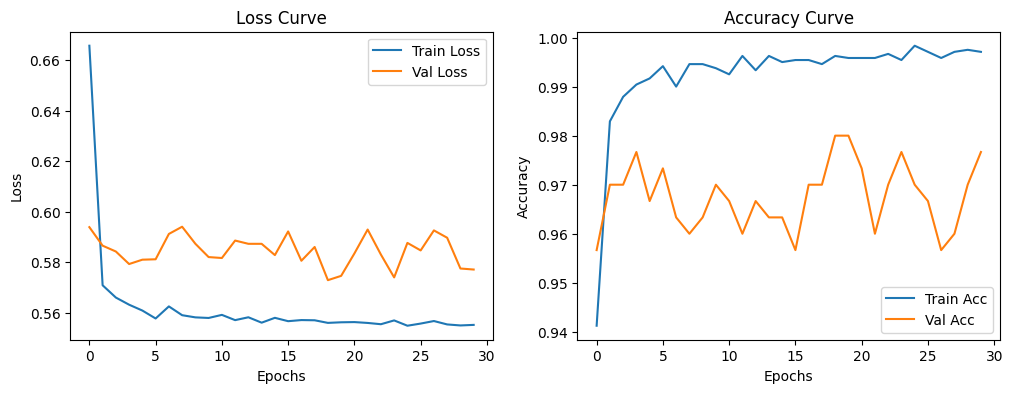

In [23]:
# Evaluate the model and generate confusion matrix
cm = evaluate_model(resnet50_2, test_loader)

# Plot confusion matrix
labels = dataset.classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot training results
plt.figure(figsize=(12, 4))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()